In [1]:
import pandas as pd
import numpy as np
import datetime as dt

import statsmodels.api as sm
import statsmodels.formula.api as smf

from stargazer.stargazer import Stargazer
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_breusch_godfrey
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.stats.diagnostic import het_breuschpagan

In [2]:
# Carregando dados tratados e separando a variável-alvo: o PIB

data = pd.read_csv('../../data/data_tf.csv')
# data['Date'] = pd.date_range(start = '2002-03-01', end = '2022-09-01', freq = 'QS-DEC') --> se fosse para trimestre 
data['Date'] = pd.date_range(start = '2002-01-01', end = '2022-09-01', freq = 'MS')
data.set_index('Date', inplace = True)
gdp = data['gdp']
qgdp = (gdp.groupby(pd.PeriodIndex(gdp.index, freq = 'Q'), axis = 0)).mean()

# Carregando os dados tranformados com PCA

data_pca = pd.read_csv('../../data/data_tfpca.csv')
# data['Date'] = pd.date_range(start = '2002-03-01', end = '2022-09-01', freq = 'QS-DEC') --> se fosse para trimestre 
data['Date'] = pd.date_range(start = '2002-01-01', end = '2022-09-01', freq = 'MS')
data_pca.set_index('Date', inplace = True)
data_pca.columns = data_pca.columns.str.replace(r"[C]", "F")

# Selecionando apenas um fator da base de dados, que iremos utilizar apenas para esse modelo

# data_pca = data_pca[['F1', 'F2', 'F3', 'F4', 'F5', 'F6', 'F7', 'F8', 'F9', 'F10', 'F11']]

# Agrupando os fatores pela média para ficar na mesma frequência do PIB e preenchendo a primeira observação do PIB com a mediana 

qdata_pca = (data_pca.groupby(pd.PeriodIndex(data_pca.index, freq = 'Q'), axis = 0)).mean()
# qdata_pca.to_csv('../../data/qdata_tfpca.csv')
new_data = pd.merge(qgdp, qdata_pca, how='inner', left_index=True, right_index=True)
new_data.gdp.fillna(new_data.gdp.median(), inplace = True)
new_data['gdp'] = new_data['gdp'] * 100
new_data.index = pd.date_range(start = '2002-03-01', end = '2022-09-01', freq = 'QS-DEC')
new_data

C:\Users\HENRI\AppData\Local\Temp\ipykernel_8804\1221982585.py:16: FutureWarning: The default value of regex will change from True to False in a future version.
  data_pca.columns = data_pca.columns.str.replace(r"[C]", "F")


,gdp,F1,F2,F3,F4,F5,F6,F7,F8,F9,F10,F11
2002-03-01,0.388552,0.538712,0.492187,0.393648,0.491212,-0.599411,0.437357,3.542712,-1.410008,1.441429,0.024750,1.164838
2002-06-01,4.320709,-0.442968,-0.049328,-0.098923,0.011377,-0.766521,0.555046,2.055331,-1.683349,2.263962,-1.414056,1.427494
2002-09-01,3.543887,0.424707,-0.647956,0.217876,-4.446846,-1.604402,1.708108,2.452098,0.985706,2.723189,-2.060487,1.139600
2002-12-01,-0.217573,-0.232993,-2.268012,6.315600,-11.643441,-3.549546,1.241341,2.347363,-0.177495,3.033051,-1.434443,0.645385
2003-03-01,-4.746729,-1.958564,0.865307,3.212400,-5.975119,-1.915151,0.577081,4.299099,-1.396467,0.792031,0.023317,1.337094
...,...,...,...,...,...,...,...,...,...,...,...,...
2021-09-01,2.578462,-0.342376,0.778500,2.328568,-1.987400,-0.206580,-0.136194,-1.399026,1.282804,-0.357813,0.517160,-0.088135
2021-12-01,-0.432211,1.693068,-3.285857,2.140440,-3.050982,1.034121,-0.989648,-1.303261,1.347845,1.466352,1.267444,-0.986221
2022-03-01,-0.262737,-2.583732,2.756302,0.194961,-5.354888,-1.059385,1.439377,-0.281474,0.233960,-3.768976,2.572942,0.308770
2022-06-01,1.786737,-0.366600,-0.601419,0.377088,-1.336048,-1.747521,-0.829394,0.277045,2.288487,-4.953368,-2.686125,1.381419


In [3]:
# train and test dates

train_start_date = "2002-03-01"
train_end_date = "2017-12-01"
test_start_date = "2018-03-01"
test_end_date = "2022-09-01"

# train and test datasets

train = new_data.loc[(new_data.index >= train_start_date) & (new_data.index <= train_end_date), :]
test = new_data.loc[(new_data.index >= test_start_date) & (new_data.index <= test_end_date), :]

# Train dataset

X_train = train.drop('gdp', axis = 1)
y_train = train['gdp']

# Test dataset 

X_test = test.drop('gdp', axis = 1)
y_test = test['gdp']

In [5]:
# Com dados da amostra - 2002 a 2017

reg = smf.ols('gdp ~ F1 + F2 + F3 + F4 + F5 + F5 + F6 + F7 + F8 + F9 + F10 + F11', data = new_data)
dfm = reg.fit(cov_type = 'HC1')
print(dfm.summary())

                            OLS Regression Results                            
Dep. Variable:                    gdp   R-squared:                       0.680
Model:                            OLS   Adj. R-squared:                  0.630
Method:                 Least Squares   F-statistic:                     12.64
Date:                Tue, 17 Jan 2023   Prob (F-statistic):           7.97e-13
Time:                        22:30:21   Log-Likelihood:                -158.19
No. Observations:                  83   AIC:                             340.4
Df Residuals:                      71   BIC:                             369.4
Df Model:                          11                                         
Covariance Type:                  HC1                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.6484      0.193      3.357      0.0

In [6]:
# Com dados da amostra - 2002 a 2017

reg = smf.ols('gdp ~ F1 + F2 + F3 + F4 + F5 + F5 + F6 + F7 + F8 + F9 + F10 + F11', data = train)
dfm = reg.fit(cov_type = 'HC1')
print(dfm.summary())

                            OLS Regression Results                            
Dep. Variable:                    gdp   R-squared:                       0.757
Model:                            OLS   Adj. R-squared:                  0.705
Method:                 Least Squares   F-statistic:                     20.99
Date:                Tue, 17 Jan 2023   Prob (F-statistic):           2.17e-15
Time:                        22:30:37   Log-Likelihood:                -108.31
No. Observations:                  64   AIC:                             240.6
Df Residuals:                      52   BIC:                             266.5
Df Model:                          11                                         
Covariance Type:                  HC1                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.9008      0.178      5.061      0.0

In [7]:
# Modelo calibrado para prever resultados fora da amostra

# test_1fac = test[['F1']].copy()
list_11fac = list()

reg = smf.ols('gdp ~ F1 + F2 + F3 + F4 + F5 + F5 + F6 + F7 + F10 + F11', data = new_data.loc['2002Q1':'2017Q4',])
dfm_11fac = reg.fit()
pred = dfm_11fac.predict(test.loc['2018Q1']).values[0]
list_11fac.append(pred)

for i, j in zip(test.index, new_data.loc['2018Q2':,].index):
    reg = smf.ols('gdp ~ F1 + F2 + F3 + F4 + F5 + F5 + F6 + F7 + F10 + F11', data = new_data.loc['2002Q1':i,])
    dfm_11fac = reg.fit()
    pred = dfm_11fac.predict(test.loc[j]).values[0]
    list_11fac.append(pred)

list_11fac

[0.24027288799610053,
 3.886831715964361,
 2.8949311479781614,
 -1.9346159620740426,
 -1.555860215946259,
 2.409699928136275,
 2.9816750320775873,
 -1.2607544049437003,
 -1.06305452464425,
 4.116088126846943,
 4.402118636193829,
 0.492309054078361,
 1.7814338779727124,
 3.3356151413455866,
 0.6445169277709466,
 -1.711025380103461,
 0.0861600717594398,
 1.0328761496141508,
 1.3504763058043738]

<AxesSubplot: >

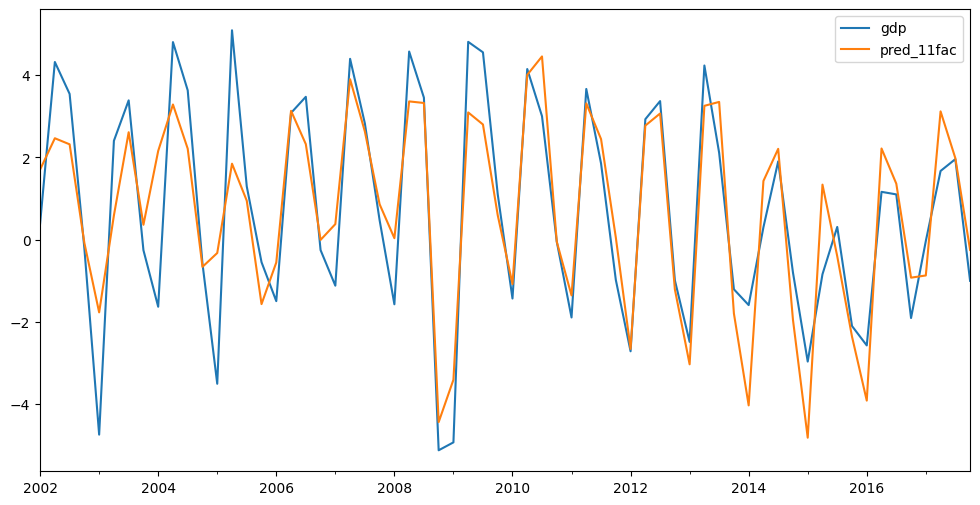

In [8]:
# Previsões IN-SAMPLE

forecasts_insample = pd.DataFrame()
forecasts_insample['gdp'] = y_train
forecasts_insample['pred_11fac'] = dfm.predict(X_train)
forecasts_insample.plot(figsize = (12,6))

<AxesSubplot: >

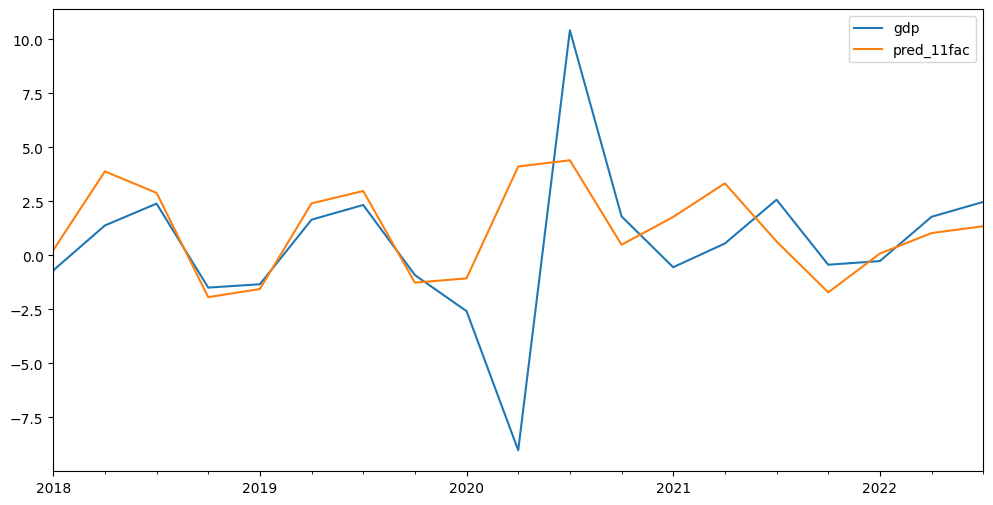

In [9]:
# Previsões OUT-OF-SAMPLE

forecasts_outsample = pd.DataFrame()
forecasts_outsample['gdp'] = y_test
forecasts_outsample['pred_11fac'] = list_11fac
forecasts_outsample.plot(figsize = (12,6))